In [28]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
from tqdm import tqdm
from skimage.transform import radon
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

In [29]:
def util_map(is_malignant):
    if is_malignant:
        return 1
    else:
        return 0

total = pd.read_csv('data/ddi_metadata.csv')
total['aux'] = total['malignant'].map(util_map)
skin_tones = {}
skin_tones[12] = total.query('skin_tone == 12')
skin_tones[34] = total.query('skin_tone == 34')
skin_tones[56] = total.query('skin_tone == 56')

In [30]:
def extract_channel_features(mag_log):

    # Mean and Variance of Frequency Magnitude
    mean_freq = np.mean(mag_log)
    var_freq = np.var(mag_log)

    # Radial Frequency Distribution

    # This creates a radial summary (a rough approximation)
    theta = np.linspace(0., 180., 128, endpoint=False)
    sinogram = radon(mag_log, theta=theta, circle=True)

    # Take the mean across angles as a simple feature
    radial_profile = np.mean(sinogram, axis=1)

    # Energy bands
    def band_energy(mag_spec, band='low'):
        h, w = mag_spec.shape
        cy, cx = h // 2, w // 2
        Y, X = np.ogrid[:h, :w]
        distance = np.sqrt((X - cx)**2 + (Y - cy)**2)
        max_radius = np.max(distance)
        if band == 'low':
            mask = distance < max_radius * 0.33
        elif band == 'mid':
            mask = (distance >= max_radius * 0.33) & (distance < max_radius * 0.66)
        elif band == 'high':
            mask = distance >= max_radius * 0.66
        return np.sum(mag_spec[mask] ** 2)

    low = band_energy(mag_log, 'low')
    mid = band_energy(mag_log, 'mid')
    high = band_energy(mag_log, 'high')

    # Entropy
    prob = mag_log / np.sum(mag_log)
    ent = entropy(prob.ravel() + 1e-8, base=2)

    # Histogram (10 bins)
    hist, _ = np.histogram(mag_log, bins=10, range=(0, np.max(mag_log)))
    hist = hist / np.sum(hist)

    return np.hstack([mean_freq, var_freq, radial_profile, low, mid, high, ent, hist])

def extract_fourier_features(image_path):
    full_features = []

    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))

    for i in range(3):
        channel = img[:, :, i]
        f = np.fft.fft2(channel)
        fshift = np.fft.fftshift(f)
        mag = np.abs(fshift)

        mag_log = 20 * np.log(mag + 1e-8) # Magnitude Spectrum

        channel_features = extract_channel_features(mag_log)
        full_features.extend(channel_features)
    
    return np.array(full_features)


In [31]:
def predict_all(df, loops=100):
    features = []
    labels = []

    for row in df.to_dict(orient='records'):
        features.append(extract_fourier_features(f'data/{row['DDI_file']}'))
        labels.append(row['aux'])

    features = np.nan_to_num(features, nan=0.0, posinf=1e6, neginf=0.0)
    X = np.array(features)
    y = np.array(labels)
    
    general_accuracy = 0
    general_precision = 0
    general_confusion_matrix = np.zeros((2, 2), dtype=float)

    for i in tqdm(range(loops)):
        pca = PCA(n_components=10)
        X_pca = pca.fit_transform(X)

        sm = SMOTE()
        X_resampled, y_resampled = sm.fit_resample(X_pca, y)

        X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2)

        clf = RandomForestClassifier(n_estimators=100)
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        #print(classification_report(y_test, y_pred))
        general_confusion_matrix += confusion_matrix(y_test, y_pred, labels=[0, 1])

        general_accuracy += accuracy_score(y_test, y_pred)
        general_precision += precision_score(y_test, y_pred, average='macro')

    general_accuracy = general_accuracy/loops
    general_precision = general_precision/loops

    print('\n---------------------------------------------------')
    print(f'General Accuracy = {general_accuracy}')
    print(f'General Precision = {general_precision}')

    
    return general_confusion_matrix/loops

/home/paoebom/micromamba/envs/img-pro-trab/lib/python3.12/site-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(
100%|██████████| 100/100 [00:19<00:00,  5.05it/s]


---------------------------------------------------
General Accuracy = 0.7956701030927837
General Precision = 0.797622545333625


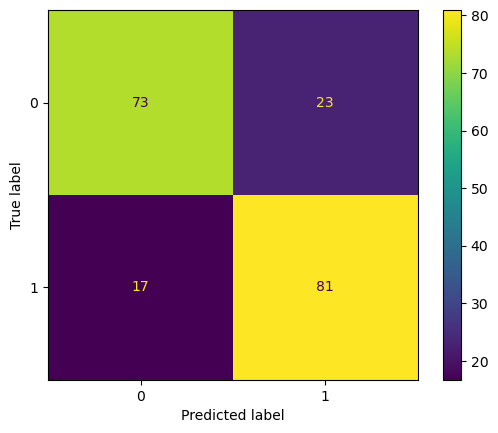

In [32]:
cm = predict_all(total)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

/home/paoebom/micromamba/envs/img-pro-trab/lib/python3.12/site-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(
100%|██████████| 100/100 [00:09<00:00, 10.61it/s]


---------------------------------------------------
General Accuracy = 0.81765625
General Precision = 0.8199393154927824


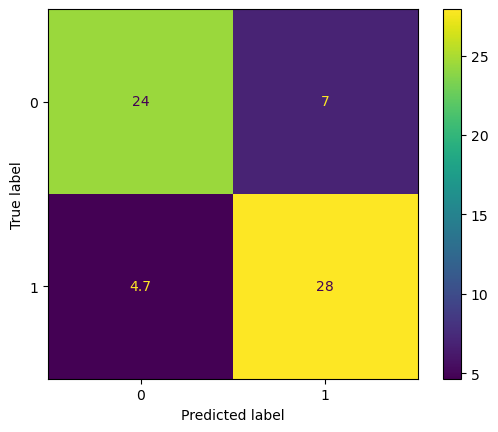

In [33]:
cm = predict_all(skin_tones[12])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

/home/paoebom/micromamba/envs/img-pro-trab/lib/python3.12/site-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(
100%|██████████| 100/100 [00:09<00:00, 10.31it/s]



---------------------------------------------------
General Accuracy = 0.7850746268656718
General Precision = 0.7872299608874016


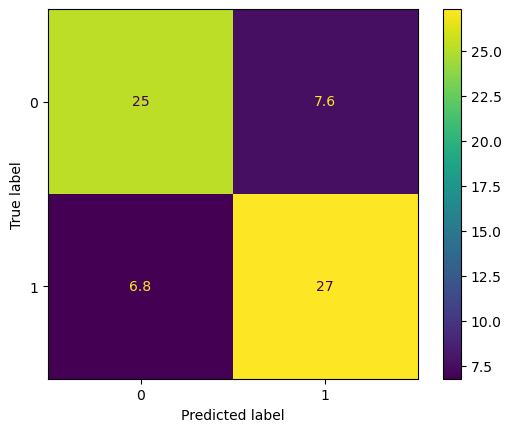

In [34]:
cm = predict_all(skin_tones[34])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

/home/paoebom/micromamba/envs/img-pro-trab/lib/python3.12/site-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(
100%|██████████| 100/100 [00:09<00:00, 10.63it/s]



---------------------------------------------------
General Accuracy = 0.84390625
General Precision = 0.8459617163429766


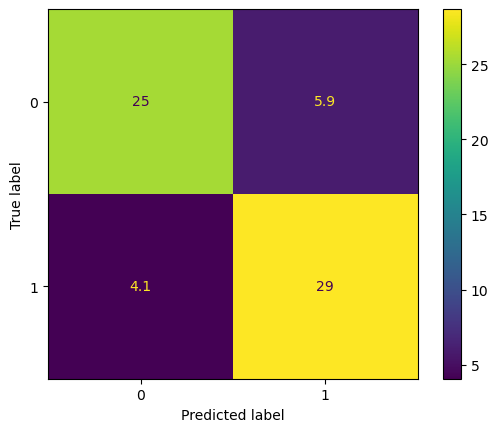

In [35]:
cm = predict_all(skin_tones[56])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()